In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Importing necessary libraries

In [14]:
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf 
import pandas as pd
import os

In [15]:
data_path = r'/kaggle/input/militaryaircraftdetectiondataset/crop'

#### Splitting the data

In [17]:
import splitfolders
splitfolders.ratio(
    data_path,
    output = "crop-splitted",
    seed = 1337,
    ratio = (0.7, 0.2, 0.1),
)

Copying files: 36519 files [02:28, 246.19 files/s]


In [18]:
os.listdir(r'/kaggle/working/crop-splitted')

['train', 'val', 'test']

In [19]:
train_data_path = r'/kaggle/working/crop-splitted/train'
val_data_path = r'/kaggle/working/crop-splitted/val'
test_data_path = r'/kaggle/working/crop-splitted/test'

#### Preparing the data

In [21]:
# Preparing the training dataset
train_data = train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    subset="training",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the validation dataset
val_data = tf.keras.utils.image_dataset_from_directory(
    val_data_path,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    subset="validation",
    validation_split=0.2,
    seed=50,
    shuffle=True,
)

# Preparing the test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    batch_size=32,
    image_size=(256, 256),
    color_mode="rgb",
)
classes = train_data.class_names

Found 25521 files belonging to 85 classes.
Using 20417 files for training.
Found 7267 files belonging to 85 classes.
Using 1453 files for validation.
Found 3731 files belonging to 85 classes.


#### Displaying images present in the training data

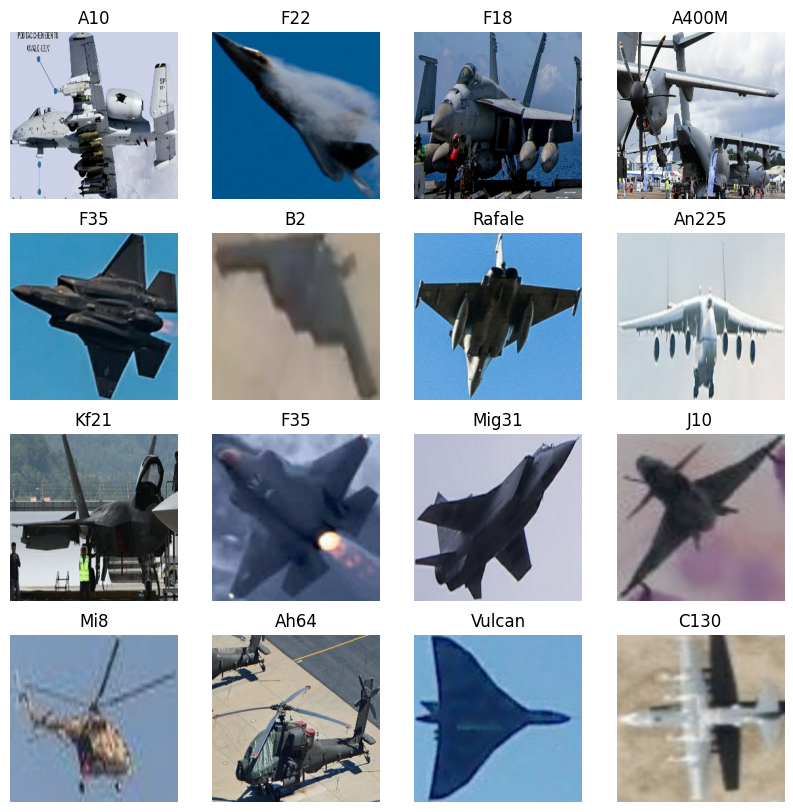

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]].title())
        plt.axis("off")
plt.show()

#### Defining the model

In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [29]:
# ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs, outputs)

# Compiling
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 85)                  │         174,165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,761,877 (90.64 MB)

 Trainable params: 174,165 (680.33 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [32]:
# Fitting
model_history = model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1750689144.832341     138 service.cc:148] XLA service 0x7fa75c003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750689144.877348     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750689144.877607     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750689147.089372     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/639 ━━━━━━━━━━━━━━━━━━━━ 3:45:28 21s/step - accuracy: 0.0000e+00 - loss: 5.3173

I0000 00:00:1750689155.049953     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


639/639 ━━━━━━━━━━━━━━━━━━━━ 106s 133ms/step - accuracy: 0.1750 - loss: 3.7534 - val_accuracy: 0.4157 - val_loss: 2.2997
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 72s 113ms/step - accuracy: 0.4467 - loss: 2.1464 - val_accuracy: 0.4990 - val_loss: 2.0277
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.5344 - loss: 1.7399 - val_accuracy: 0.5389 - val_loss: 1.8823
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.5910 - loss: 1.5056 - val_accuracy: 0.5588 - val_loss: 1.8442
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.6220 - loss: 1.3669 - val_accuracy: 0.5409 - val_loss: 1.9103
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.6330 - loss: 1.3187 - val_accuracy: 0.5444 - val_loss: 1.8765
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.6470 - loss: 1.2398 - val_accuracy: 0.5547 - val_loss: 1.8895
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 71s 111ms/step - accuracy: 0.6716 - loss: 1.1478 - va

#### Fine-tuning the model

In [34]:
base_model.trainable = True
# Re-compiling with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# Fitting the model again
model_history = model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 341s 409ms/step - accuracy: 0.4623 - loss: 2.3455 - val_accuracy: 0.6332 - val_loss: 1.6082
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 369ms/step - accuracy: 0.7245 - loss: 0.9613 - val_accuracy: 0.6848 - val_loss: 1.3777
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 369ms/step - accuracy: 0.8216 - loss: 0.6258 - val_accuracy: 0.7054 - val_loss: 1.2746
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 369ms/step - accuracy: 0.8852 - loss: 0.4170 - val_accuracy: 0.7247 - val_loss: 1.2240
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 237s 371ms/step - accuracy: 0.9279 - loss: 0.2869 - val_accuracy: 0.7343 - val_loss: 1.1883
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 370ms/step - accuracy: 0.9521 - loss: 0.2030 - val_accuracy: 0.7405 - val_loss: 1.1577
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 370ms/step - accuracy: 0.9696 - loss: 0.1390 - val_accuracy: 0.7405 - val_loss: 1.1691
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 236s 370ms/step - accuracy: 0.9784 -

In [36]:
# Saving the model
model.save('classifier.keras')

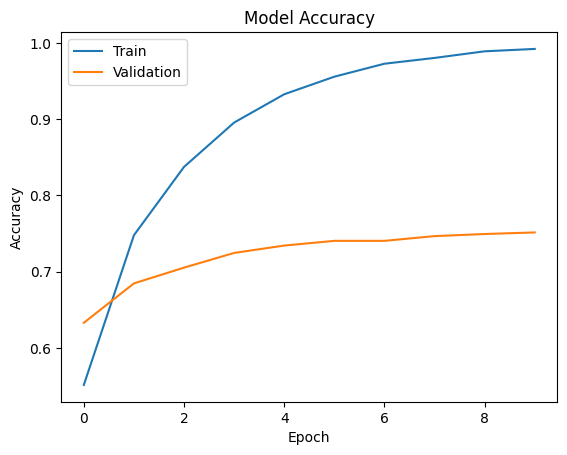

In [37]:
# Accuracy history summary
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

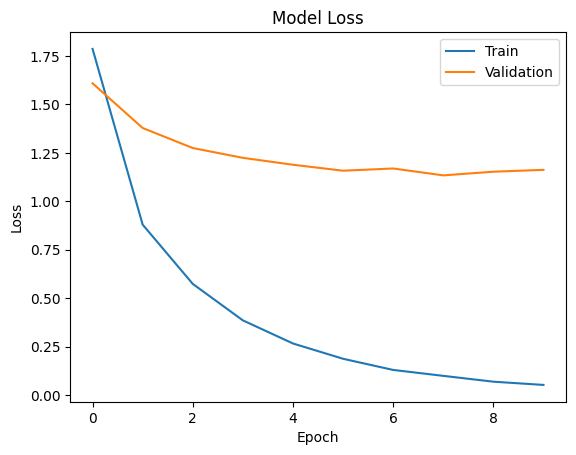

In [38]:
# Loss history summary
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Metrics

In [41]:
validation_accuracy = model.evaluate(val_data)
test_accuracy = model.evaluate(test_data)

print(f"validation accuracy : {validation_accuracy[1]}")
print(f"test accuracy : {test_accuracy[1]}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7539 - loss: 1.1138
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7419 - loss: 1.1444
validation accuracy : 0.7515485286712646
test accuracy : 0.7451085448265076
